# Modelisation

## Importation des modules et du dataset

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler

data = pd.read_csv("dataset_cleaned.csv")

## Transformation des variables 

In [29]:
bmi_scale = [
    {"category": "Underweight", "range": [float("-inf"), 18.499]},
    {"category": "Healthy weight", "range": [18.5, 24.999]},
    {"category": "Overweight", "range": [25, 29.999]},
    {"category": "Obesity class I", "range": [30, 34.999]},
    {"category": "Obesity class II", "range": [35, 39.999]},
    {"category": "Obesity class III", "range": [40, float("inf")]},
]

bmi_count = []
for bmi in data["bmi"]:
    for group in bmi_scale:
        if bmi >= group["range"][0] and bmi <= group["range"][1]:
            bmi_count.append(group["category"])
            continue

data = data.drop("bmi", axis=1)
data["bmi"] = bmi_count

## Création des train set et test set

In [30]:
X = data.drop("charges", axis=1)
y = data.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

## Etapes de preprocessing 

In [31]:
num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

preprocessing = ColumnTransformer([
    ("one_hot", OneHotEncoder(), cat_col),
    ("scaling", StandardScaler(), num_col),
])

## Régression Lasso

In [32]:
lasso_model = Lasso(alpha=37.3)

pipe_lasso = make_pipeline(preprocessing, PolynomialFeatures(2), lasso_model)
display(pipe_lasso)

pipe_lasso.fit(X_train, y_train)
pipe_lasso.score(X_test, y_test)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one_hot', OneHotEncoder(),
                                                  ['sex', 'smoker', 'region',
                                                   'bmi']),
                                                 ('scaling', StandardScaler(),
                                                  ['age', 'children'])])),
                ('polynomialfeatures', PolynomialFeatures()),
                ('lasso', Lasso(alpha=37.3))])

0.922984950453674

## Analyse des coefficients des features

In [33]:
feature_names = pipe_lasso[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    pipe_lasso.named_steps["lasso"].coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs["absolute_values"] = coefs["Coefficients"].abs()

coefs = coefs.sort_values(by=["absolute_values"], ascending=False)
coefs = coefs.drop("absolute_values", axis=1)

coefs.to_csv("coef.csv")

display(coefs.head(11))

,Coefficients
one_hot__smoker_yes one_hot__bmi_Obesity class III,19336.583053
one_hot__smoker_yes one_hot__bmi_Obesity class II,18089.166678
one_hot__smoker_yes one_hot__bmi_Obesity class I,15851.297225
one_hot__smoker_no,-14230.714660
scaling__age,3475.600484
one_hot__smoker_yes one_hot__bmi_Healthy weight,-2093.970686
scaling__age^2,772.473113
one_hot__region_southwest,-658.039003
one_hot__region_northeast one_hot__bmi_Obesity class II,488.998561
one_hot__smoker_no one_hot__region_northeast,487.988456


## Graph de la régression Lasso

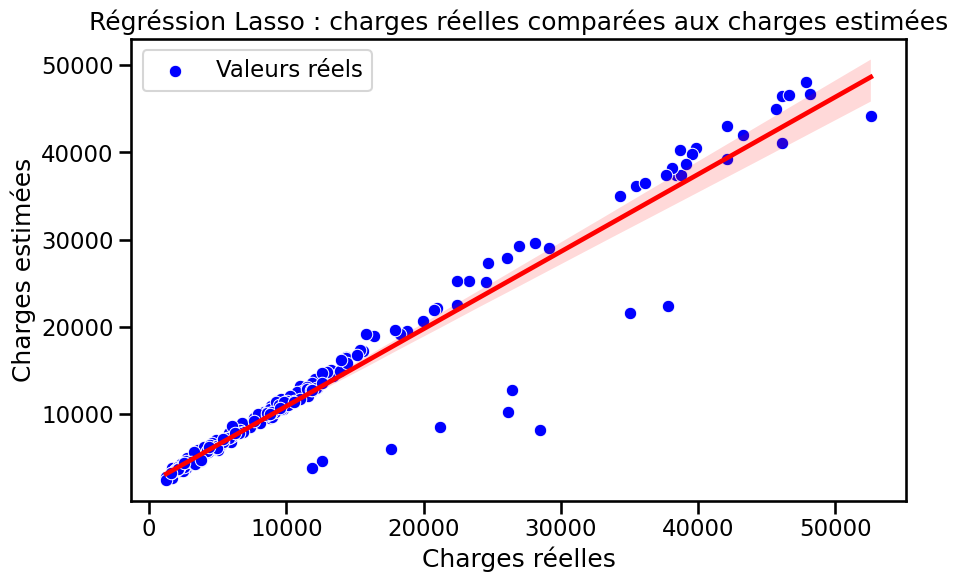

In [34]:
y_pred = pipe_lasso.predict(X_test)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue", label="Valeurs réels")
sns.regplot(x=y_test, y=y_pred, scatter=False, color="red")

plt.title("Régréssion Lasso : charges réelles comparées aux charges estimées")
plt.xlabel("Charges réelles")
plt.ylabel("Charges estimées")

plt.show()

## Serialisation du model dans un fichier pkl

In [35]:
with open("model.pkl", "wb") as file:
    pickle.dump(pipe_lasso, file)
file.close()